In [1]:
from functools import partial
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant, safe_logodds
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-03 23:14:02.877701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-03 23:14:02.877749: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train=100096
num_val=20000
noise_level=0.01
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="gauss", threshold=0.5,
                                  noise_distribution="gauss", noise_scale=s)
x, y = eg.generate_labeled(num_train + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train:, :], y[num_train:]
#return x_train, y_train, x_val, y_val

In [3]:
layers = (
    keras.layers.Dense(30, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(30, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(30, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(1, activation="sigmoid")
)
mcd_classifier = MCDropoutKerasClassification(
    layer_tuple=layers,
    optimizer=keras.optimizers.SGD(learning_rate=0.006),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="MCDropout"
)
mcd_classifier.fit(
    x_train,
    y_train,
    epochs=84,
    batch_size=256,
    validation_data=(x_val, y_val)
)

Epoch 1/84


2022-05-03 23:14:07.218587: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-03 23:14:07.220008: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-03 23:14:07.220050: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-03 23:14:07.220424: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


391/391 [==============================] - 3s 5ms/step - loss: 0.6967 - accuracy: 0.5341 - auc: 0.5467 - val_loss: 0.6637 - val_accuracy: 0.6031 - val_auc: 0.6413
Epoch 2/84
391/391 [==============================] - 2s 4ms/step - loss: 0.6276 - accuracy: 0.6617 - auc: 0.7226 - val_loss: 0.5861 - val_accuracy: 0.7116 - val_auc: 0.7874
Epoch 3/84
391/391 [==============================] - 1s 3ms/step - loss: 0.5337 - accuracy: 0.7553 - auc: 0.8370 - val_loss: 0.4780 - val_accuracy: 0.7942 - val_auc: 0.8748
Epoch 4/84
391/391 [==============================] - 1s 4ms/step - loss: 0.4179 - accuracy: 0.8243 - auc: 0.9062 - val_loss: 0.3683 - val_accuracy: 0.8456 - val_auc: 0.9262
Epoch 5/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3205 - accuracy: 0.8708 - auc: 0.9446 - val_loss: 0.2841 - val_accuracy: 0.8852 - val_auc: 0.9553
Epoch 6/84
391/391 [==============================] - 2s 4ms/step - loss: 0.2548 - accuracy: 0.8977 - auc: 0.9637 - val_loss: 0.2289 - val_ac

Epoch 48/84
391/391 [==============================] - 1s 3ms/step - loss: 0.0258 - accuracy: 0.9903 - auc: 0.9997 - val_loss: 0.0252 - val_accuracy: 0.9908 - val_auc: 0.9997
Epoch 49/84
391/391 [==============================] - 1s 3ms/step - loss: 0.0253 - accuracy: 0.9911 - auc: 0.9997 - val_loss: 0.0251 - val_accuracy: 0.9906 - val_auc: 0.9997
Epoch 50/84
391/391 [==============================] - 1s 3ms/step - loss: 0.0237 - accuracy: 0.9917 - auc: 0.9997 - val_loss: 0.0255 - val_accuracy: 0.9905 - val_auc: 0.9996
Epoch 51/84
391/391 [==============================] - 1s 3ms/step - loss: 0.0237 - accuracy: 0.9920 - auc: 0.9997 - val_loss: 0.0250 - val_accuracy: 0.9908 - val_auc: 0.9997
Epoch 52/84
391/391 [==============================] - 1s 3ms/step - loss: 0.0240 - accuracy: 0.9911 - auc: 0.9997 - val_loss: 0.0229 - val_accuracy: 0.9915 - val_auc: 0.9998
Epoch 53/84
391/391 [==============================] - 1s 4ms/step - loss: 0.0233 - accuracy: 0.9916 - auc: 0.9997 - val_loss

In [4]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

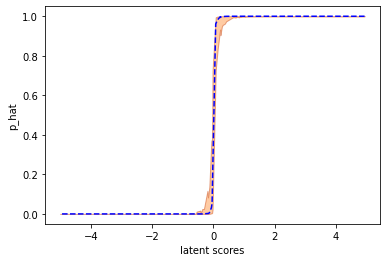

In [5]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

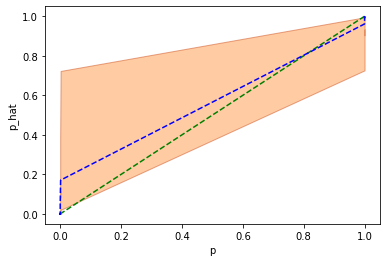

In [6]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [7]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

For noise level: 0.01: 47.349999999999994% within 90% CI


/tmp/ipykernel_138334/1528285081.py:4: RuntimeWarning: invalid value encountered in true_divide
  normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)


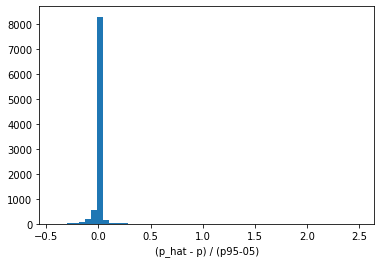

In [8]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.01: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
plt.hist(normed_p_dist, bins=50)
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

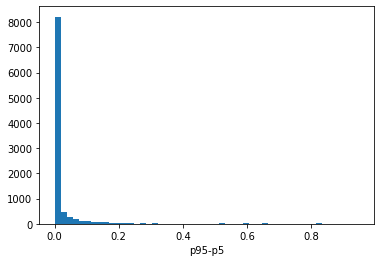

In [9]:
plt.hist(p_h - p_l, bins=50)
plt.xlabel('p95-p5')
plt.show()

In [10]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train=100096
num_val=20000
noise_level=0.1
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="gauss", threshold=0.5,
                                  noise_distribution="gauss", noise_scale=s)
x, y = eg.generate_labeled(num_train + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train:, :], y[num_train:]
#return x_train, y_train, x_val, y_val

In [11]:
layers = (
    keras.layers.Dense(30, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(30, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(30, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(1, activation="sigmoid")
)
mcd_classifier = MCDropoutKerasClassification(
    layer_tuple=layers,
    optimizer=keras.optimizers.SGD(learning_rate=0.006),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="MCDropout"
)
mcd_classifier.fit(
    x_train,
    y_train,
    epochs=80,
    batch_size=256,
    validation_data=(x_val, y_val)
)

Epoch 1/80
391/391 [==============================] - 3s 5ms/step - loss: 0.6826 - accuracy: 0.5584 - auc: 0.5845 - val_loss: 0.6681 - val_accuracy: 0.5964 - val_auc: 0.6481
Epoch 2/80
391/391 [==============================] - 1s 3ms/step - loss: 0.6479 - accuracy: 0.6443 - auc: 0.7059 - val_loss: 0.6244 - val_accuracy: 0.6760 - val_auc: 0.7492
Epoch 3/80
391/391 [==============================] - 2s 4ms/step - loss: 0.5844 - accuracy: 0.7167 - auc: 0.7971 - val_loss: 0.5334 - val_accuracy: 0.7598 - val_auc: 0.8434
Epoch 4/80
391/391 [==============================] - 2s 4ms/step - loss: 0.4809 - accuracy: 0.7848 - auc: 0.8720 - val_loss: 0.4238 - val_accuracy: 0.8146 - val_auc: 0.9008
Epoch 5/80
391/391 [==============================] - 2s 4ms/step - loss: 0.3727 - accuracy: 0.8431 - auc: 0.9241 - val_loss: 0.3305 - val_accuracy: 0.8625 - val_auc: 0.9392
Epoch 6/80
391/391 [==============================] - 1s 4ms/step - loss: 0.2939 - accuracy: 0.8794 - auc: 0.9518 - val_loss: 0.26

Epoch 48/80
391/391 [==============================] - 2s 4ms/step - loss: 0.0591 - accuracy: 0.9788 - auc: 0.9976 - val_loss: 0.0567 - val_accuracy: 0.9776 - val_auc: 0.9979
Epoch 49/80
391/391 [==============================] - 2s 4ms/step - loss: 0.0569 - accuracy: 0.9796 - auc: 0.9978 - val_loss: 0.0572 - val_accuracy: 0.9788 - val_auc: 0.9979
Epoch 50/80
391/391 [==============================] - 1s 4ms/step - loss: 0.0571 - accuracy: 0.9790 - auc: 0.9978 - val_loss: 0.0566 - val_accuracy: 0.9793 - val_auc: 0.9978
Epoch 51/80
391/391 [==============================] - 1s 3ms/step - loss: 0.0567 - accuracy: 0.9795 - auc: 0.9979 - val_loss: 0.0567 - val_accuracy: 0.9791 - val_auc: 0.9980
Epoch 52/80
391/391 [==============================] - 1s 3ms/step - loss: 0.0566 - accuracy: 0.9793 - auc: 0.9979 - val_loss: 0.0563 - val_accuracy: 0.9796 - val_auc: 0.9980
Epoch 53/80
391/391 [==============================] - 1s 3ms/step - loss: 0.0557 - accuracy: 0.9801 - auc: 0.9979 - val_loss

In [12]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

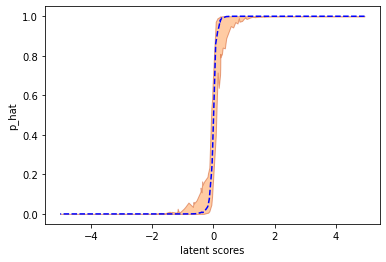

In [13]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

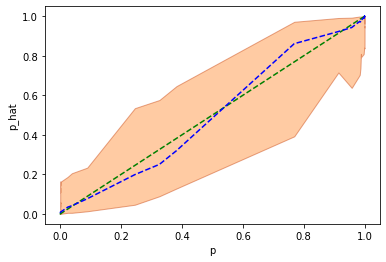

In [14]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [15]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

For noise level: 0.1: 51.09% within 90% CI


/tmp/ipykernel_138334/3165455278.py:4: RuntimeWarning: invalid value encountered in true_divide
  normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)


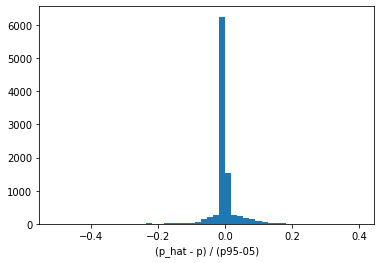

In [16]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.1: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
plt.hist(normed_p_dist, bins=50)
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

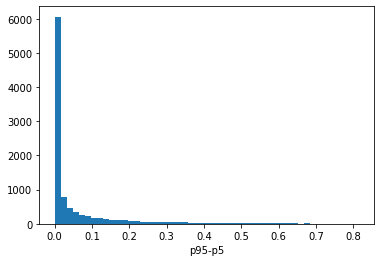

In [17]:
plt.hist(p_h - p_l, bins=50)
plt.xlabel('p95-p5')
plt.show()

In [18]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train=100096
num_val=20000
noise_level=0.3
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="gauss", threshold=0.5,
                                  noise_distribution="gauss", noise_scale=s)
x, y = eg.generate_labeled(num_train + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train:, :], y[num_train:]
#return x_train, y_train, x_val, y_val

In [19]:
layers = (
    keras.layers.Dense(30, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(30, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(30, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(1, activation="sigmoid")
)
mcd_classifier = MCDropoutKerasClassification(
    layer_tuple=layers,
    optimizer=keras.optimizers.SGD(learning_rate=0.006),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="MCDropout"
)
mcd_classifier.fit(
    x_train,
    y_train,
    epochs=82,
    batch_size=256,
    validation_data=(x_val, y_val)
)

Epoch 1/82
391/391 [==============================] - 3s 5ms/step - loss: 0.6933 - accuracy: 0.5340 - auc: 0.5506 - val_loss: 0.6726 - val_accuracy: 0.5847 - val_auc: 0.6173
Epoch 2/82
391/391 [==============================] - 1s 3ms/step - loss: 0.6563 - accuracy: 0.6121 - auc: 0.6589 - val_loss: 0.6322 - val_accuracy: 0.6508 - val_auc: 0.7087
Epoch 3/82
391/391 [==============================] - 1s 3ms/step - loss: 0.6005 - accuracy: 0.6892 - auc: 0.7576 - val_loss: 0.5610 - val_accuracy: 0.7233 - val_auc: 0.7999
Epoch 4/82
391/391 [==============================] - 1s 3ms/step - loss: 0.5174 - accuracy: 0.7556 - auc: 0.8365 - val_loss: 0.4680 - val_accuracy: 0.7870 - val_auc: 0.8701
Epoch 5/82
391/391 [==============================] - 1s 3ms/step - loss: 0.4226 - accuracy: 0.8149 - auc: 0.8960 - val_loss: 0.3766 - val_accuracy: 0.8399 - val_auc: 0.9180
Epoch 6/82
391/391 [==============================] - 1s 3ms/step - loss: 0.3435 - accuracy: 0.8560 - auc: 0.9316 - val_loss: 0.31

Epoch 48/82
391/391 [==============================] - 2s 4ms/step - loss: 0.1312 - accuracy: 0.9462 - auc: 0.9894 - val_loss: 0.1322 - val_accuracy: 0.9469 - val_auc: 0.9892
Epoch 49/82
391/391 [==============================] - 2s 4ms/step - loss: 0.1313 - accuracy: 0.9466 - auc: 0.9893 - val_loss: 0.1350 - val_accuracy: 0.9456 - val_auc: 0.9887
Epoch 50/82
391/391 [==============================] - 2s 4ms/step - loss: 0.1319 - accuracy: 0.9462 - auc: 0.9892 - val_loss: 0.1302 - val_accuracy: 0.9461 - val_auc: 0.9896
Epoch 51/82
391/391 [==============================] - 2s 4ms/step - loss: 0.1300 - accuracy: 0.9469 - auc: 0.9896 - val_loss: 0.1312 - val_accuracy: 0.9449 - val_auc: 0.9893
Epoch 52/82
391/391 [==============================] - 1s 4ms/step - loss: 0.1311 - accuracy: 0.9466 - auc: 0.9894 - val_loss: 0.1325 - val_accuracy: 0.9456 - val_auc: 0.9891
Epoch 53/82
391/391 [==============================] - 1s 4ms/step - loss: 0.1305 - accuracy: 0.9471 - auc: 0.9894 - val_loss

In [20]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

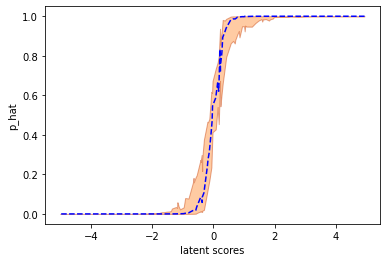

In [21]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

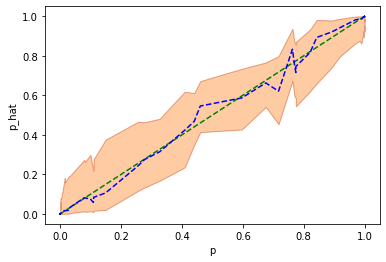

In [22]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [23]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

For noise level: 0.3: 80.83% within 90% CI


/tmp/ipykernel_138334/1348312816.py:4: RuntimeWarning: invalid value encountered in true_divide
  normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)


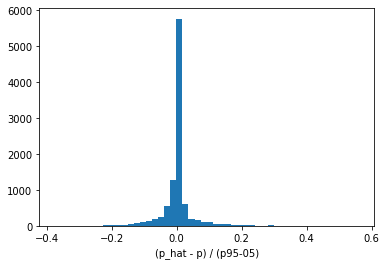

In [24]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.3: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
plt.hist(normed_p_dist, bins=50)
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

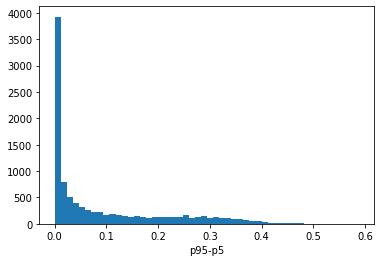

In [25]:
plt.hist(p_h - p_l, bins=50)
plt.xlabel('p95-p5')
plt.show()